In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

import zipfile
import pandas as pd
import os
from tqdm import tqdm


In [137]:
import os
import pandas as pd

path = 'ChengDuData'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

combined_dataframe = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    temp_df = pd.read_csv(file_path)
    
    # Compute the average travel time
    temp_df['Average_Travel_Time'] = temp_df.iloc[:, 8:59].mean(axis=1)
    
    # Extract time period information from file name
    time_period = file.replace('.csv', '').replace('_', ' ')
    temp_df['Time_Period'] = time_period

    # Select relevant columns (optional, depending on your model requirements)
    temp_df = temp_df[['Link', 'Node_Start', 'Longitude_Start', 'Latitude_Start', 
                       'Node_End', 'Longitude_End', 'Latitude_End', 'Length', 
                       'Average_Travel_Time', 'Time_Period']]
    
    combined_dataframe = pd.concat([combined_dataframe, temp_df], ignore_index=True)

# Now combined_dataframe contains the processed data


In [20]:
print(combined_dataframe.head())

   Link  Node_Start  Longitude_Start  Latitude_Start  Node_End  Longitude_End  \
0     0           0       103.946006       30.750660        16     103.952551   
1     1           0       103.946006       30.750660        48     103.956494   
2     2           0       103.946006       30.750660        64     103.941276   
3     3           1       104.062539       30.739077       311     104.060024   
4     4           1       104.062539       30.739077      1288     104.062071   

   Latitude_End       Length  Average_Travel_Time       Time_Period  
0     30.756752   921.041014            85.424151  Weekday Off peak  
1     30.745080  1179.207157           125.386769  Weekday Off peak  
2     30.754493   620.905375            53.618874  Weekday Off peak  
3     30.742693   467.552294            40.787167  Weekday Off peak  
4     30.732501   730.287581            77.209144  Weekday Off peak  


In [138]:
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))  # No change required here, but ensure 'a' does not exceed 1
    
    # 6371 km is the radius of the Earth
    km = 6371 * c
    return km

Preprocessing

In [139]:
# Calculate distance and add it as a new feature (haversine)
combined_dataframe['Distance'] = combined_dataframe.apply(
    lambda row: haversine(row['Longitude_Start'], row['Latitude_Start'],
                          row['Longitude_End'], row['Latitude_End']), axis=1)

# Features and targets
X = combined_dataframe[['Link', 'Node_Start', 'Longitude_Start', 'Latitude_Start', 
                        'Node_End', 'Longitude_End', 'Latitude_End', 'Distance']].values
y = combined_dataframe['Average_Travel_Time'].values  # Assuming this is your target variable

# Splitting the dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Apply the same transformation to validation data

# Convert to torch tensors
train_features = torch.tensor(X_train_scaled, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.float32)
val_features = torch.tensor(X_val_scaled, dtype=torch.float32)
val_labels = torch.tensor(y_val, dtype=torch.float32) 

In [140]:
# Creating TensorDataset objects for training and validation sets
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)

# Creating DataLoader instances to load data in batches
# You can adjust the batch_size according to your system's capabilities
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Model Architecture

In [24]:
class EnhancedTravelTimePredictor(nn.Module):
    def __init__(self):
        super(EnhancedTravelTimePredictor, self).__init__()
        self.fc1 = nn.Linear(8, 128)  # Adjust input features if necessary
        self.bn1 = nn.BatchNorm1d(128)  # Corrected to match the output features of fc1
        self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)  # Corrected to match the output features of fc3
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x


Defining device for in case gpu is not enough

In [26]:
#if gpu not enough eiei norng momo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [27]:
#model instantiation
from os import device_encoding


criterion = nn.MSELoss()
model = EnhancedTravelTimePredictor().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay for L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


c:\Users\thave\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [28]:
#checkpoint saving
model_path = './model_checkpoints'
os.makedirs(model_path, exist_ok=True)
checkpoint_name = os.path.join(model_path, 'checkpoint_{epoch}.pth')

Model Training

In [29]:
import time
from tqdm import tqdm
# Adjust early stopping parameters
num_epochs = 600000
early_stopping_threshold = 100  # Increased patience
best_val_loss = np.inf
patience_counter = 0

# Initialize lists to hold metrics for analysis
train_mae, val_mae = [], []
train_rmse, val_rmse = [], []
train_losses, val_losses = [], []

# Learning rate scheduler adjustment
# Assuming optimizer has been defined as 'optimizer'
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, min_lr=1e-6)

for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    start_time = time.time()

model.train()
epoch_train_losses, train_predictions, train_targets = [], [], []

for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    outputs = outputs.squeeze()
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
        
    epoch_train_losses.append(loss.item())
    train_predictions.extend(outputs.detach().cpu().numpy())
    train_targets.extend(targets.cpu().numpy())

    avg_train_loss = np.mean(epoch_train_losses)
    train_losses.append(avg_train_loss)
    
    epoch_train_mae = mean_absolute_error(train_targets, train_predictions)
    epoch_train_rmse = np.sqrt(mean_squared_error(train_targets, train_predictions))
    train_mae.append(epoch_train_mae)
    train_rmse.append(epoch_train_rmse)

    model.eval()
    val_predictions, val_targets, epoch_val_losses = [], [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            
            epoch_val_losses.append(loss.item())
            val_predictions.extend(outputs.detach().cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

    avg_val_loss = np.mean(epoch_val_losses)
    val_losses.append(avg_val_loss)

    epoch_val_mae = mean_absolute_error(val_targets, val_predictions)
    epoch_val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
    val_mae.append(epoch_val_mae)
    val_rmse.append(epoch_val_rmse)

    # Measure the end time after the epoch has completed
    end_time = time.time()
    seconds_per_epoch = end_time - start_time  # Calculate the duration of the epoch

   # After calling scheduler.step(), get and print the last learning rate
    scheduler.step(avg_val_loss)
    last_lr = scheduler.optimizer.param_groups[0]['lr']  # Accessing the last learning rate

    if (epoch + 1) % 1000 == 0 or patience_counter == 0:  # Print when learning rate changes or every 1000 epochs
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train MAE: {epoch_train_mae:.4f}, Train RMSE: {epoch_train_rmse:.4f}, Val Loss: {avg_val_loss:.4f}, Val MAE: {epoch_val_mae:.4f}, Val RMSE: {epoch_val_rmse:.4f}, Time: {seconds_per_epoch:.2f}s/epoch, LR: {last_lr}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_threshold:
            print(f"Stopping early at epoch {epoch + 1}")
            break


Training Progress: 100%|██████████| 600000/600000 [00:00<00:00, 4525022.84it/s]


Epoch 600000/600000, Train Loss: 6376.4766, Train MAE: 62.3425, Train RMSE: 79.8528, Val Loss: 5278.5849, Val MAE: 54.1752, Val RMSE: 72.8545, Time: 0.72s/epoch, LR: 0.001
Epoch 600000/600000, Train Loss: 7647.3301, Train MAE: 62.5103, Train RMSE: 87.4490, Val Loss: 5276.4280, Val MAE: 54.1574, Val RMSE: 72.8396, Time: 0.81s/epoch, LR: 0.001
Epoch 600000/600000, Train Loss: 7830.6279, Train MAE: 62.7991, Train RMSE: 88.4908, Val Loss: 5273.9257, Val MAE: 54.1359, Val RMSE: 72.8224, Time: 0.88s/epoch, LR: 0.001
Epoch 600000/600000, Train Loss: 7074.3535, Train MAE: 60.8522, Train RMSE: 84.1092, Val Loss: 5271.3039, Val MAE: 54.1130, Val RMSE: 72.8043, Time: 0.97s/epoch, LR: 0.001
Epoch 600000/600000, Train Loss: 6494.1559, Train MAE: 59.0989, Train RMSE: 80.5863, Val Loss: 5268.5943, Val MAE: 54.0890, Val RMSE: 72.7857, Time: 1.05s/epoch, LR: 0.001
Epoch 600000/600000, Train Loss: 6250.4141, Train MAE: 58.4421, Train RMSE: 79.0596, Val Loss: 5265.7461, Val MAE: 54.0638, Val RMSE: 72.766

In [30]:
# Save the model
path = 'models/'
# change name modle here
model_name = 'model2.pth'
torch.save(model.state_dict(), path + model_name)

In [158]:
def try_single_prediction(val_loader, model, device,n):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        # Get a single batch from the val_loader
        data, target = next(iter(val_loader))
        # Move the data and model to the same device
        data, target = data.to(device), target.to(device)
        model.to(device)
        
        # Select the first example from the batch
        single_data, single_target = data[n: n + 1], target[n:n + 1]
        # Predict
        prediction = model(single_data)
        
        # Move prediction back to CPU for item() to work if needed
        prediction = prediction.cpu()
        single_target = single_target.cpu()
        
        # Print the results
        print(f'Actual value: {single_target.item()}')
        print(f'Predicted value: {prediction.item()}')
        # Optionally, you can return these values for further processing
        return single_target.item(), prediction.item()

# Assuming 'device' is defined as follows:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# After training, try the model with one data point
actual, predicted = try_single_prediction(val_loader, model, device, 4)

# Optionally, calculate the error for this single prediction
error = abs(actual - predicted)
print(f'Prediction error: {error}')


Actual value: 49.942039489746094
Predicted value: 37.993865966796875
Prediction error: 11.948173522949219


Actual value: 64.99746704101562
Predicted value: 79.68413543701172
Actual value: 36.78788375854492
Predicted value: 57.234012603759766
Actual value: 23.48946189880371
Predicted value: 25.219650268554688
Actual value: 60.642677307128906
Predicted value: 43.5847282409668
Actual value: 49.942039489746094
Predicted value: 37.993865966796875
Actual value: 14.30167293548584
Predicted value: 21.908666610717773
Actual value: 90.2534408569336
Predicted value: 81.61750030517578
Actual value: 108.07937622070312
Predicted value: 149.39891052246094
Actual value: 35.434139251708984
Predicted value: 44.36198806762695
Actual value: 28.17169952392578
Predicted value: 37.91508483886719
Actual value: 26.930849075317383
Predicted value: 21.79658317565918
Actual value: 80.66744995117188
Predicted value: 106.79846954345703
Actual value: 15.144736289978027
Predicted value: 17.95548439025879
Actual value: 56.574886322021484
Predicted value: 58.360374450683594
Actual value: 51.301292419433594
Predicted value: 

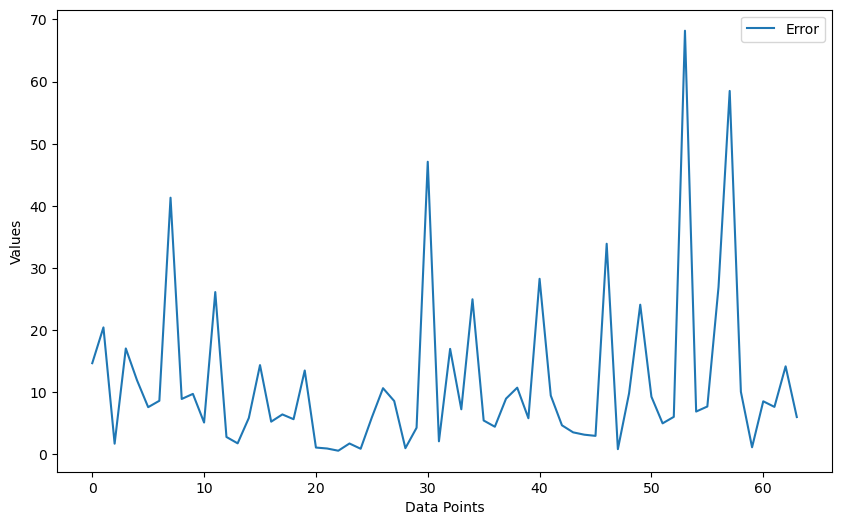

In [161]:
import matplotlib.pyplot as plt

predicted_values = []
actual_values = []
error_values = []

data, target = next(iter(val_loader))
x = [i for i in range(len(data))]
for i in range(len(data)):
    # Assuming 'device' is defined as follows:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    actual, predicted = try_single_prediction(val_loader, model, device, i)
    predicted_values.append(predicted)
    actual_values.append(actual)
    error_values.append(abs(actual - predicted))

print(predicted_values)
print(actual_values)
print(x)

# Make sure x has the same length as predicted_values and actual_values
x = range(len(predicted_values))

plt.figure(figsize=(10, 6))
# plt.plot(x, predicted_values, label='Predicted')
# plt.plot(x, actual_values, label='Actual')
plt.plot(x, error_values, label='Error')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()
plt.show()


Graphical analysis of model performance

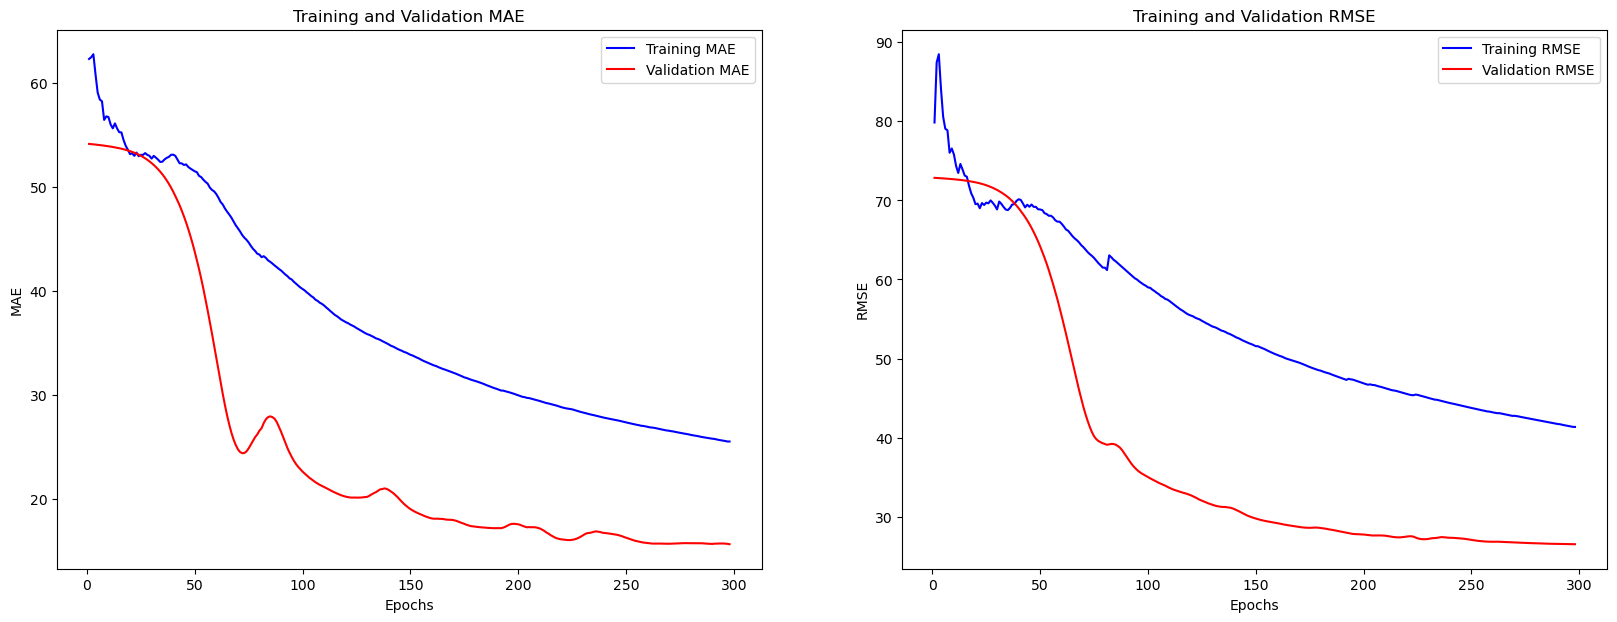

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust epochs range for plotting based on actual epochs run
epochs_adjusted = range(1, len(train_mae)+1)

# Learning curve plotting for MAE and RMSE
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# MAE Plot
ax[0].plot(epochs_adjusted, train_mae, 'b', label='Training MAE')
ax[0].plot(epochs_adjusted, val_mae, 'r', label='Validation MAE')
ax[0].set_title('Training and Validation MAE')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MAE')
ax[0].legend()

# RMSE Plot
ax[1].plot(epochs_adjusted, train_rmse, 'b', label='Training RMSE')
ax[1].plot(epochs_adjusted, val_rmse, 'r', label='Validation RMSE')
ax[1].set_title('Training and Validation RMSE')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('RMSE')
ax[1].legend()

plt.show()
